The dataset provided includes information about credit card transactions and whether they are fraudulent or not. Each row represents  various factors influencing the response variable, which indicates whether the transaction is fraudulent (1) or not (0).

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, classification_report

In [ ]:
# Load the dataset
data = pd.read_csv("Fraud_Detection_Dataset.csv")

In [ ]:
# Explore the data
print(data.head())
print(data.info())
print(data.describe())

       X1      X2      X3       X4       X5       X6       X7       X8  \
0  6.5983 -5.4256 -1.6443  13.8045   3.7169   6.7931  14.6561  11.5962   
1  7.5116 -4.3535 -4.0704  14.2800   1.8892  11.8115  14.6331   7.5008   
2  6.1407  1.3776 -6.5337  13.9074   2.5997  12.1947  14.8693  11.8861   
3  6.7580 -4.7164 -0.4525  14.2519  13.4656   5.5629  14.6345   9.9810   
4  6.1647  0.4752 -6.8146  13.7472  11.7696   8.7009  15.0317   9.4731   

        X9      X10  ...     X192     X193     X194     X195     X196  \
0 -10.0106  18.7749  ...  12.0647   2.1140  11.1032   1.3060   7.7833   
1   8.7162  10.7818  ...  -1.5024   2.8147  18.2737  -3.1967   6.8112   
2  -9.2483  23.8771  ...  -6.9850  14.2934   8.2079  -1.7949   5.8634   
3 -12.0141  17.8304  ...  -2.9186  13.1990   3.6219  -9.7055  16.9012   
4   2.1471  17.5970  ...  12.0055   5.0098   2.3963 -14.0838   6.8654   

      X197     X198    X199    X200  Response  
0 -19.1025  13.0473  1.2374  4.9343         1  
1  -9.1633  11.0487 

In [ ]:
y= data['Response']
y

0        1.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
16083    0.0
16084    0.0
16085    0.0
16086    0.0
16087    NaN
Name: Response, Length: 16088, dtype: float64

In [ ]:
y.value_counts()

0.0    14218
1.0     1869
Name: Response, dtype: int64

In [ ]:
data.corr().style.background_gradient(cmap='coolwarm')

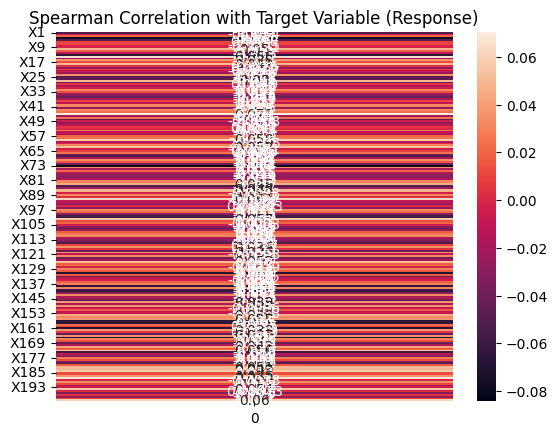

In [ ]:
# Obtain the list of numerical column names
numeric_cols = data.columns[data.columns != 'Response']

# Calculate the Spearman correlation between each numerical column and the 'Response' column
corr_with_target = data[numeric_cols].corrwith(data['Response'], method="spearman")

# Create a heatmap to visualize the correlation of each numerical column with the target variable ('Response')
sns.heatmap(pd.DataFrame(corr_with_target), annot=True)
plt.title('Spearman Correlation with Target Variable (Response)')
plt.show()


In [ ]:
data.Response.value_counts()

0.0    14218
1.0     1869
Name: Response, dtype: int64

 Data Pre-processing

In [ ]:

# Split the data into features and target
X = data.drop('Response', axis=1)
y = data['Response']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values with mean
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# Handle missing values in y_train
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()






In [ ]:
# Reset index after handling missing values
y_train.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Resampling

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Convert target variable to binary based on a threshold
threshold = 0.5
y_train_binary = (y_train > threshold).astype(int)

Model selection

In [ ]:

# Model Selection with GridSearchCV and Cross-validation
models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
}

params = {
    'Logistic Regression': {'C': [0.1, 1.0, 10.0]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7]},
    'Decision Tree': {'max_depth': [None, 5, 10]},
}

best_models = {}
for name, model in models.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, params[name], cv=cv)
    grid_search.fit(X_train_scaled, y_train_binary)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate the models
results = {}
for name, model in best_models.items():
    score = model.score(X_test_scaled, y_test)
    results[name] = score

# Find the best model
best_model = max(results, key=results.get)
print(f"The best model is: {best_model} with a score of {results[best_model]}")


Running GridSearchCV for Logistic Regression...
Best parameters for Logistic Regression: {'C': 1.0}
Running GridSearchCV for K-Nearest Neighbors...
Best parameters for K-Nearest Neighbors: {'n_neighbors': 7}
Running GridSearchCV for Decision Tree...
Best parameters for Decision Tree: {'max_depth': 5}
The best model is: Logistic Regression with a score of 0.90665625


In [ ]:
from sklearn.linear_model import LogisticRegression

# Build the final Logistic Regression model with the best parameters
best_logistic_regression_model = LogisticRegression(C=1.0)
best_logistic_regression_model.fit(X_train_scaled, y_train_binary)

# Evaluate the final model on the test set
test_score = best_logistic_regression_model.score(X_test_scaled, y_test)
print(f"Test set accuracy of the final Logistic Regression model: {test_score}")


Test set accuracy of the final Logistic Regression model: 0.90665625


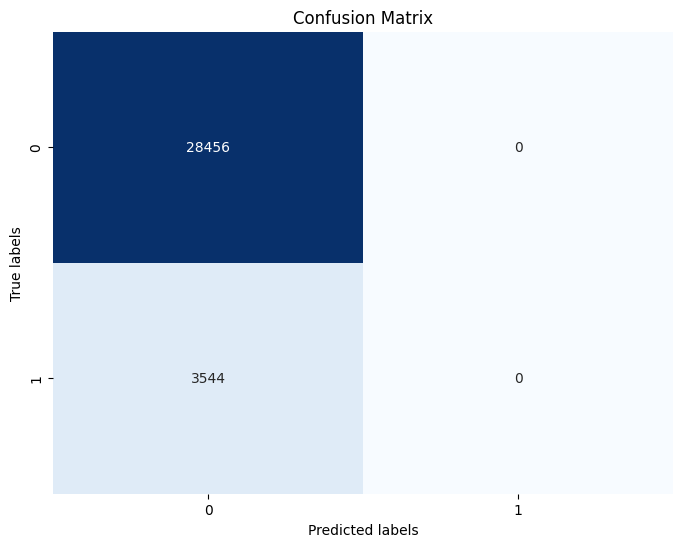

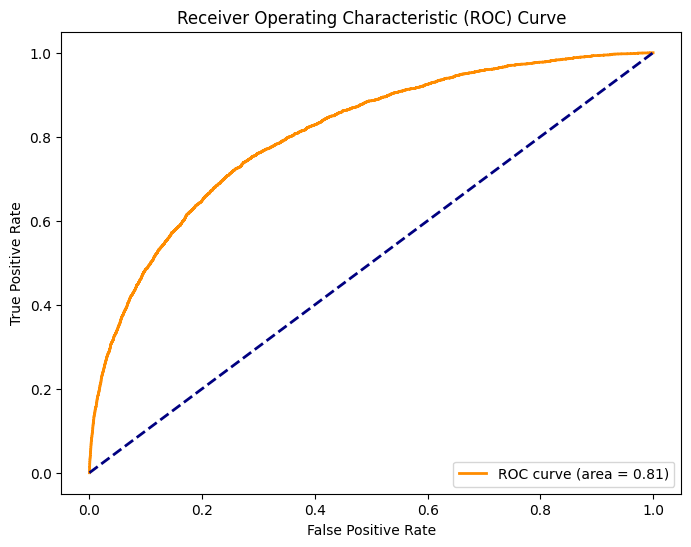

Accuracy: 0.89
Precision: 0.89
Recall: 0.89


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# ROC Curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Other Metrics
def print_other_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred)

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_proba)

# Print Other Metrics
print_other_metrics(y_test, y_pred)


Based on the test set accuracy, Decision Tree and K-Nearest Neighbours models performed poorly in this instance than Logistic Regression.
The regularisation parameter (C) for Logistic Regression was also discovered to be optimal at 1.0, suggesting that the complexity of the model was suitably balanced during the selection process.
Finally, Logistic Regression was chosen as the best model for this credit fraud dataset because to its higher performance in terms of accuracy on the testing set.

ANALYSIS

In [64]:
testdata= pd.read_csv("Fraud_Detection_Test_nik.csv")

In [65]:
# Explore the data
(testdata.head())

X1      X2       X3       X4       X5       X6       X7       X8  \
0  7.4666 -1.3580  -7.1440  13.7381  12.9590   4.9841  15.0051  12.3663   
1  8.2909 -4.3991   0.4326  13.9596   0.6847   9.6088  14.5882  15.2369   
2  9.0983  2.4051   4.5059  14.2550  12.5132  11.1552  14.6549   9.7035   
3  9.0035  0.5599  -8.2703  14.0180   5.1023   9.5449  14.4064  10.9887   
4  9.5074 -0.7764 -12.9365  13.8708   6.3865   3.0093  14.9760   8.9447   

        X9      X10  ...    X191    X192    X193     X194    X195     X196  \
0 -22.4177   3.8168  ...  7.9725 -0.9971  9.1948  26.3943  5.1431  12.0758   
1  -5.3908   8.9019  ...  8.0846 -3.8670  5.9071   6.0043 -1.5445  15.2656   
2  -6.1696   6.6330  ...  9.1789 -2.8283  3.6028  24.8727 -3.4591   7.1799   
3   3.2565  11.1293  ...  8.8858  3.2907  7.5241  20.5310 -3.4199   4.4391   
4 -10.9938  12.8367  ...  7.4449  4.4764  8.6799  16.5777 -2.9865  12.1084   

     X197     X198    X199    X200  
0 -3.8012  15.4609  1.2080  4.1482  
1 -0.7045  15.6133  0.3530 -0.5345  
2 -8.6247  10.5007 -0.0816  3.9596  
3 -9.0842  16.6371  2.3548  2.5903  
4 -0.4005  13.0723  1.2873  8.8247  

[5 rows x 200 columns]

In [66]:
testdata.isna().sum()

X1      0
X2      0
X3      0
X4      0
X5      0
       ..
X196    0
X197    0
X198    0
X199    0
X200    0
Length: 200, dtype: int64

In [67]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Columns: 200 entries, X1 to X200
dtypes: float64(200)
memory usage: 15.3 MB


In [62]:
object_columns = testdata.select_dtypes(include=['object']).columns
print("Object columns:", object_columns)

Object columns: Index(['X3'], dtype='object')


In [68]:
y_pred=best_logistic_regression_model.predict(testdata)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [69]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [70]:
df_y=pd.DataFrame(y_pred,columns=['y_hat'])
df_y.head()

y_hat
0      0
1      0
2      0
3      0
4      0

In [74]:
df_y.to_csv('Team-8.csv',index=False)

In [75]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Define the file name
file_name = 'Team-8.csv'

# Concatenate the directory path and the file name to get the full file path
file_path = os.path.join(current_directory, file_name)

# Print the file path
print("File Path:", file_path)


File Path: /content/Team-8.csv
